## Paramétrage d'un profil longitdunal

Un profil longitudinal est constitué d'un élément de base qui se répète. L'élément de base est un quadruplet, position en 2 d  du point de départ, pente, ces trois informations définissent une droite, et rayon de raccordement  entre cette droite et la suivante.

L'algorithme consiste à construire les droites. Puis à construire leurs parallèles situés à une distance égale au rayon de raccordement. L'intersection de ces deux parallèles donne le centre du cercle qui permet de raccorder les deux droites. 
Les projections perpendiculaires de l'intersection sur chacune des droites donne le début et la fin de la partie ciculaire du profil.

Ce principe est illustré par le schéma suivant  :

http://ggbm.at/SeDfCnk3



La construction consiste alors à échantillonner les deux droites et l'arc de cercle sur une longueur de 1m (en abscisse). 

L'algorithme suppose de tracer une droite parallèle à une autre à une distance donnée. La formule utilisée dans la fonction parallele(a,b,r) qui est définie dans le code ci-dessous est illustrée par la schéma suivant :
http://ggbm.at/yeJ93nBt

    


*Voies de Progrès*

    Attention, l'échantillonnage de l'arc de cercle est approximé en supposant une variation linéaire de la pente ce qui est faux. 


Cet algorithme est implémenté dans le code suivant

In [8]:
import math
import numpy as np


def equation_droite(pente,point):
    "défini l'équiation de la droite à partir d'une pente et d'un point"
    plongi=point[0]
    altitude=point[1]
    a=pente/100;
    b=altitude-a*plongi;# a*point + b = altitude
    return a,b
    
def intersection(a1,b1,a2,b2):
    " défini l'intersection de deux droites "
    W=np.array([[-a1, 1],[-a2,1]])
    Y=np.array([b1,b2])
    sol=np.linalg.solve(W,Y)
    x = sol[0]
    y=  sol[1] 
    #print("intersection", x,y)
    return x,y
    
def perpendiculaire(a,b,x,y):
     a_perp=-1/a
     b_perp=y-a_perp*x
     return a_perp,b_perp
     
    
def parallele(a,b,r):
    "construction d'une parallèle à la distrance r de la droite ax+b"
    c=abs(a*r*math.sqrt(1/(1+a*a)))
    b_par=b+(abs(c/a)+abs(a*c))*np.sign(r)
    return a, b_par
    

def raccordement(a1,b1,a2,b2,r):
    " raccordement de deux droites par un cercle de rayon r"
    convexe=np.sign(a2-a1) # si c'est convexe convexe=1,  si concave, convexe=-1
    rsigne = convexe*r
    a1_par, b1_par = parallele(a1,b1,rsigne)
    a2_par, b2_par = parallele(a2,b2,rsigne)  
    xc,yc = intersection(a1_par,b1_par,a2_par,b2_par)
    a_perp,b_perp=perpendiculaire(a1_par, b1_par, xc, yc)
    xdeb_cercle, ydeb_cercle = intersection(a_perp, b_perp, a1, b1)
    a_perp,b_perp=perpendiculaire(a2_par, b2_par, xc, yc)
    xfin_cercle, yfin_cercle = intersection(a_perp, b_perp, a2, b2)
    return xdeb_cercle, ydeb_cercle, xfin_cercle, yfin_cercle
    
    
# Test unitaire effectuté graphiquement sur le cahier pour vérifier
# que la fonction raccordement fonctionne bien
#pente1=-1/2*100
#x1=0
#y1=0
#point1=np.array([x1,y1])
#pente2=1/5*100
#x2=0
#y2=-7.5
#point2=np.array([x2,y2])
#r=4
#
#a1,b1 = equation_droite(pente1,point1)
#a2,b2 = equation_droite(pente2,point2)    
#xd,yd,xf,yf=raccordement(a1,b1,a2,b2,r)


def profil_en_long(point_de_depart, pente1,point_de_fin,pente2,pas,r,drapeau_fin)    :
    a1,b1= equation_droite(pente1, point_de_depart)
    a2,b2= equation_droite(pente2, point_de_fin)
    
    xd,yd,xf,yf=raccordement(a1,b1,a2,b2,r)
    extension=10000*pas
    abscisse = np.arange(point_de_depart[0]-extension, point_de_fin[0]+extension, pas) 
    abscisse1 = abscisse[abscisse<xd] ;
    abscisse1c= abscisse[abscisse>=xd] ;
    
    abscisse2 = abscisse[abscisse>xf] ;
    abscisse2c= abscisse[abscisse<=xf] ;
    
    altitude1= a1*abscisse1+b1
    altitude2= a2*abscisse2+b2
    
    abscisse_debut_rac = abscisse1c[0]
    abscisse_fin_rac = abscisse2c[-1]
    
    n_rac = round((abscisse_fin_rac-abscisse_debut_rac)/pas+1) 
    abscisse_cercle = np.linspace(abscisse_debut_rac, abscisse_fin_rac, n_rac, endpoint=True) 
    altitude_cercle= np.zeros_like(abscisse_cercle)
    dpente = (pente2/100-pente1/100)/n_rac ;
    pentek=pente1/100
    altitude_cercle[0]=altitude1[-1]+pentek*pas;
    k=1
    for abscissek in abscisse_cercle[1:].tolist():
        pentek=pentek+dpente
        altitude_cercle[k]=altitude_cercle[k-1]+pentek*pas
        k=k+1
    altitude=np.concatenate((altitude1, altitude_cercle, altitude2))
    
    k_drapeau=-1 
    if drapeau_fin: 
        k_drapeau=1
    indice=np.where((abscisse>(point_de_depart[0]-pas/2)) & (abscisse <(point_de_fin[0]+k_drapeau*pas/2)))
    abscisse=abscisse[indice[0]]
    altitude=altitude[indice[0]]    
    return abscisse, altitude
    
#test unitaire en comparaiant avec calcul coordonnees.xlsx
# cela fonctionne impeccable
# j'ai vérifié sur certains points
# le calcul du cercle fonctionne bien
# le code suivant fonctionne
#pente1=-5.215
#point_de_depart=np.array([0,375.42])
#r=3015.17891
#pente2=-0.502
#point_de_fin=np.array([711,352.51])
#pas=1
#x,y=profil_en_long(point_de_depart, pente1,point_de_fin,pente2,pas,r,True) 

# Le code suivant bogue
#pente1=-0.502
#point_de_depart==np.array([480,353.67])
#r=13508.0
#pente2=-1.883
#point_de_fin==np.array([2169,326.36])
#pas=1
#x,y=profil_en_long(point_de_depart, pente1,point_de_fin,pente2,pas,r,True) 


#pente1=2.032
#point_de_depart=np.array([4600.0,323.57])
#r=50000.0
#pente2=0.923
#point_de_fin=np.array([6457.0,331.57])
#pas=1
#x,y=profil_en_long(point_de_depart, pente1,point_de_fin,pente2,pas,r,True) 



# Cela marche super sauf pour les cas où il y a deux rayons qui s'enchainent...
# dans ce cas, c'est problématique
# il faut mettre une pente de valeur nulle


def reconstruction_du_profil(limites):
    pas=1
    limite_prec=limites[0]
    n=len(limites)
    #recouvrement = 120 # on prend un point 120m avant pour éviter que le rayon soit nul
    for k in range(1,n,1):
            limite=limites[k]    
            point_de_depart=np.array(limite_prec[0:2])
            pente1=limite_prec[2]
            r=limite_prec[3]
            point_de_fin=np.array(limite[0:2])
            pente2=limite[2]
            drapeau_fin= (k==n)
            x,y=profil_en_long(point_de_depart, pente1,point_de_fin,pente2,pas,r, drapeau_fin) 
            limite_prec=limite       
            if k==1:
                abscisse=np.copy(x)
                altitude=np.copy(y)
            else:
                abscisse=np.concatenate((abscisse,x))
                altitude=np.concatenate((altitude,y))
    return abscisse, altitude

La modélisation du profil consiste à enchainer des quadruplets comprenant les éléments suivants
    * abscisse
    * altitude
    * pente exprimé en pourcents
Ces trois éléments définissent une droite
    * rayon du cercle qui permettra de relier cette droite à la suivante

La liste limites_de_section modélise donc le profil longitudinal.

Ceci donne les degrés de liberté du programme d'optimisation : il y a 15 éléments, soit 60 variables, le début et la fin sont fixés, il reste 56 degrés de liberté...

Voie de progrès
Il faudra tenir compte de l'Ictaal afin de limiter les plages de variations.
Il faudra gérer les profils irréalisables


In [9]:
limites_de_section=[[0,375.42, -5.215, 3015], 
                    [711, 352.51, -0.502,13508],
[2169, 326.36 ,-1.883, 30023],
[2871, 319.60, -0.620, 10073],
[3131, 321.37,1.985, 14969], 
[4035, 318.99, -0.996, 14955],
[4300, 318.68, 0.75,14657],
[4900, 329.67, 2.032, 10491],
[5435, 326.92, -3.15, 8014],
[5860, 325.19, 2.3, 9872],
[6457,331.57,0.923, 7789], 
[6532,332.61,1.871, 10539], 
[7260, 338.18, 0.656, 14622],
[8365, 334.87,-0.372,14825],
[8810, 328.29,-1.843]]
#lorsque le projeteur a mis deux cercles l'un derrière l'autre un convexe et un concave, j'ai mis un seul rayon de 15000

x,y=reconstruction_du_profil(limites_de_section)

Le test unitaire consiste à comparer le profil trouvé avec ce code avec le profil du projet réel.

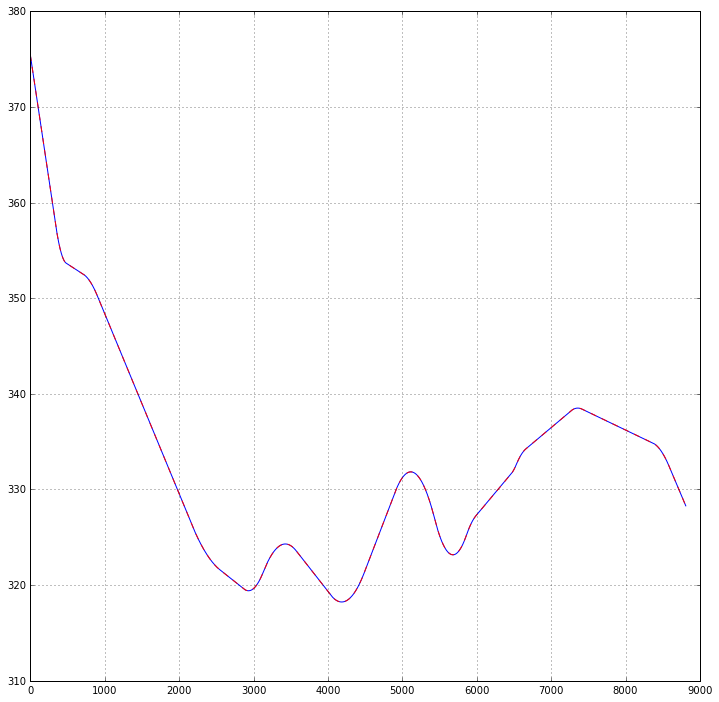

In [10]:
abscisse_projet_initial=np.load("abscisse.npy")
altitude_projet_initial=np.load("altitude.npy") 

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(abscisse_projet_initial, altitude_projet_initial,'b-', x,y,'r--')
plt.grid()
plt.show()
